In [170]:
import numpy as np

COLORS = {
    "Gray": np.array([169, 169, 169]),
    "LightGray": np.array([217, 217, 217]),
    "DarkGray": np.array([117, 117, 117]),
    "DarkRed": np.array([238, 125, 95]),
    "LightRed": np.array([247, 207, 196]),
    "DarkRedBorder": np.array([202, 65, 35]),
    "Yellow": np.array([255, 201, 67]),
    "LightYellow": np.array([255, 236, 189]),
    "LightGreen": np.array([213, 243, 214]),
    "Green": np.array([131, 211, 127]),
    "GreenBorder": np.array([88, 153, 84]),
    "LightBlue": np.array([201, 228, 252]),
    "LightBlueBorder": np.array([94, 171, 248]),
    "Blue": np.array([94, 171, 248]),
    "Black": np.array([40, 45, 50]),
    "White": np.array([255, 255, 255]),
    "LightPink": np.array([246, 196, 233]),
    "Pink": np.array([229, 87, 189]),
}

# Install packages
```cmd
pip install psycopg

```


In [17]:
import psycopg
from psycopg.rows import dict_row

def getDbConn():
    return psycopg.connect(
        host="localhost",
        dbname="tdt4900",
        user="postgres",
        password="postgres",
        row_factory=dict_row
    )


# Execution Time vs. Levels

In [20]:
db_conn = getDbConn()
execution_times = {}

simulation_ids = [124,123,122,123,125,126,127]

for sim_id in simulation_ids:
    simulation = db_conn.cursor().execute(f'SELECT * FROM "Simulations" WHERE "Id" = {sim_id}').fetchall()[0]
    graph_id = simulation['GraphId']

    execution_time = simulation['AlgorithmExecutionTime']
    level = db_conn.cursor().execute(f'SELECT "Levels" FROM "Graphs" WHERE "Id" = {graph_id}').fetchall()[0]['Levels']



    execution_times[level] = execution_time

db_conn.close()

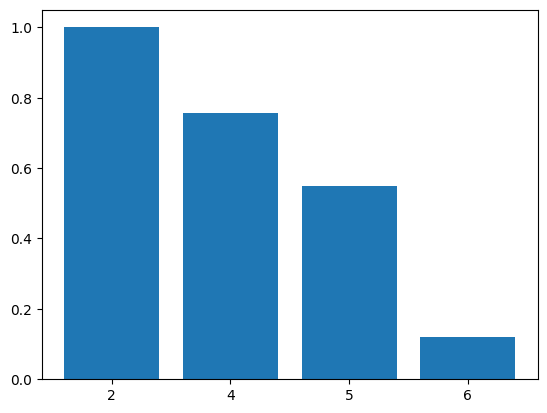

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fix, ax = plt.subplots()
x = np.array(sorted(execution_times.keys()))
y = np.array([execution_times[i] for i in x])

# Normalize (
norm_y = y / (y.max())

x = [str(num + 1) for num in x]

plt.bar(x, norm_y)
plt.show()

# Execution Time / Path Length
Also includes standard deviation from execution times

In [132]:
db_conn = getDbConn()
execution_times = {}

sim_batch_ids = {41, 35, 36, 38, 39}

for sim_batch_id in sim_batch_ids:

    simulations = db_conn.cursor().execute(f'SELECT * FROM "Simulations" WHERE "SimulationBatchId" = {sim_batch_id}').fetchall()

    levels = db_conn.cursor().execute(f'SELECT * FROM "Graphs" INNER JOIN "Simulations" ON "Simulations"."GraphId" = "Graphs"."Id" WHERE "Simulations"."SimulationBatchId" = {sim_batch_id} LIMIT 1').fetchall()[0]['Levels']

    execution_times[levels] = []

    for simulation in simulations:
        graph_id = simulation['GraphId']
        shortest_path_length = simulation['ShortestPathLength']
        execution_time = simulation['AlgorithmExecutionTime']

        execution_time_factor = execution_time

        execution_times[levels].append(execution_time_factor)

db_conn.close()

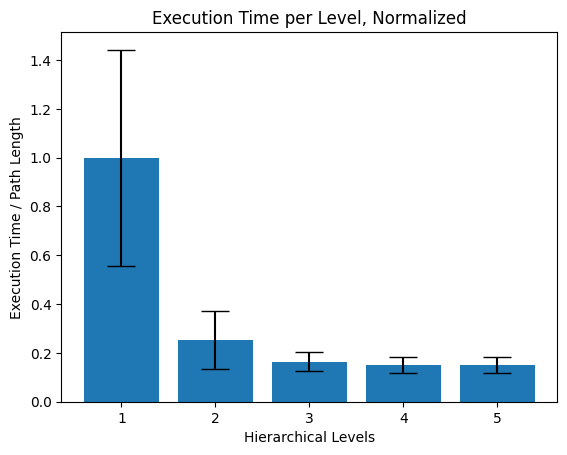

In [133]:
import matplotlib.pyplot as plt
import numpy as np

fix, ax = plt.subplots()
x = np.array(sorted(execution_times.keys()))

y = []
conf_intervals = []

for level in x:
    val = execution_times[level]
    mean = np.mean(val)
    std_dev = np.std(val) / 2.0
    y.append(mean)
    conf_intervals.append(std_dev)

x = [str(num) for num in x]
y = np.array(y)
conf_intervals = np.array(conf_intervals)

norm_y = y / (y.max())
norm_conf_intervals = conf_intervals / y.max()

plt.bar(x, norm_y, yerr=norm_conf_intervals, capsize=10)

plt.title('Execution Time per Level, Normalized')
plt.ylabel('Execution Time / Path Length')
plt.xlabel('Hierarchical Levels')

plt.show()

# Execution Time / Path Length - Compared to Path Length on single level

In [193]:
db_conn = getDbConn()
execution_times = {}

sim_batch_ids = {41,35,36,38,39}

for sim_batch_id in sim_batch_ids:

    simulations = db_conn.cursor().execute(f'SELECT * FROM "Simulations" WHERE "SimulationBatchId" = {sim_batch_id} LIMIT 100').fetchall()

    levels = db_conn.cursor().execute(f'SELECT * FROM "Graphs" INNER JOIN "Simulations" ON "Simulations"."GraphId" = "Graphs"."Id" WHERE "Simulations"."SimulationBatchId" = {sim_batch_id} LIMIT 1').fetchall()[0]['Levels']

    execution_times[levels] = {}

    for simulation in simulations:
        graph_id = simulation['GraphId']
        shortest_path_length = simulation['ShortestPathLength']
        execution_time = simulation['AlgorithmExecutionTime']

        execution_time_factor = execution_time

        execution_times[levels][shortest_path_length] = execution_time_factor

db_conn.close()

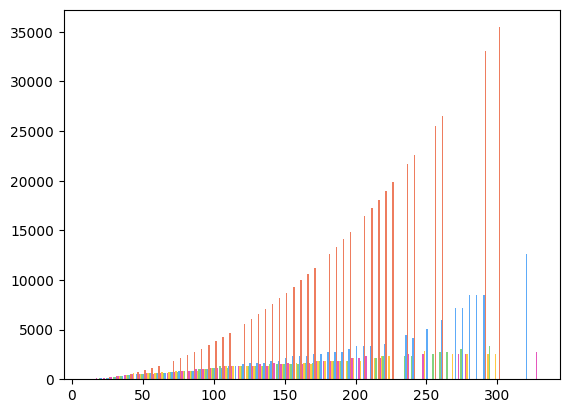

In [194]:
import matplotlib.pyplot as plt
import numpy as np

fix, ax = plt.subplots()

clrs = [
    COLORS["DarkRed"],
    COLORS["Blue"],
    COLORS["Green"],
    COLORS["Yellow"],
    COLORS["Pink"],
]

for level in execution_times.keys():
    x = np.array(sorted(execution_times[level].keys()))
    y = np.array([execution_times[level][i] for i in x])

    plt.bar(x*5 + (2.5 - level), y, width=1, color=clrs[level - 1] / 255.0)

plt.show()